# HMC: higher-order integrators

Florent Leclercq,<br/>
Institut d'Astrophysique de Paris,<br/>
florent.leclercq@iap.fr

In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm, uniform
from math import floor
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
from cycler import cycler
np.random.seed(123456)

In [2]:
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': r"\usepackage{amsmath}\usepackage{upgreek}"})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 15})
dir="./plots/MCMC_Hamiltonian_4th_order/"
!mkdir -p $dir

## The target pdf

In [3]:
def target_joint(x,y):
    return x*x * np.exp(-x*y*y -y*y +2.*y -4.*x)
def target_marginal_x(x):
    return x*x/np.sqrt(x+1) * np.exp(-4.*x -1./(x+1.))
def target_marginal_y(y):
    return np.exp(-y*y+2.*y) / (y*y+4.)**3
def psi(x,y,Ncalls=-1):
    # psi(x,y)=-ln(target_joint(x,y))
    ans = np.where((x > 1e-10) & (x < 1e2) & (np.fabs(y) < 1e2), -2.*np.log(np.fabs(x)) +x*y*y +y*y -2.*y +4.*x, +1e8)
    if Ncalls>=0:
        return ans, Ncalls+1
    else:
        return ans
def dpsi_dx(x,y,Ncalls=-1):
    ans = np.where((x > 1e-10) & (x < 1e2) & (np.fabs(y) < 1e2), -2./x +y*y* +4., +1e8)
    if Ncalls>=0:
        return ans, Ncalls+1
    else:
        return ans
def dpsi_dy(x,y,Ncalls=-1):
    ans = np.where((x > 1e-10) & (x < 1e2) & (np.fabs(y) < 1e2), 2.*x*y +2.*y -2., +1e8)
    if Ncalls>=0:
        return ans, Ncalls+1
    else:
        return ans

In [4]:
# Normalization of the marginals
Nx=quad(target_marginal_x,0.0001,100.)[0]
Ny=quad(target_marginal_y,-100.,100.)[0]

In [5]:
xmin=0.01
xmax=2.
ymin=-1.
ymax=2.5
x=np.linspace(xmin,xmax,1000)
y=np.linspace(ymin,ymax,1000)
X,Y=np.meshgrid(x,y)
Z=target_joint(X,Y)
Psi=psi(X,Y)
dPsi_dx=dpsi_dx(X,Y)
dPsi_dy=dpsi_dy(X,Y)

## Auto-correlation diagnostics

In [6]:
# Based on python code from the emcee tutorials, https://emcee.readthedocs.io/en/stable/tutorials/autocorr/

def next_power_of_2(n: int) -> int:
    """Smallest power of two ≥ n."""
    return 1 << (n - 1).bit_length() if n > 0 else 1

# 1D autocorrelation function
def autocorr_func_1d(x, norm=True):
    """
    Compute the 1D autocorrelation via FFT in O(N log N).
    If norm=True, normalize so acf[0] = 1.
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    nfft = 2 * next_power_of_2(n)

    # real FFT
    f = np.fft.rfft(x - np.mean(x), n=nfft)
    ps = (f * f.conjugate()).real      # power spectrum
    acf = np.fft.irfft(ps, n=nfft)[:n]
    acf /= 2 * nfft

    # normalise
    if norm:
        if acf[0] <= 0:
            return 0 # or raise ValueError("Autocorrelation function is zero or negative at lag 0.")
        else:
            acf /= acf[0]
    return acf

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    """
    Return the first lag k for which k < c * tau_k fails.
    If none fail, return len(taus)-1.
    """
    k = np.arange(len(taus))
    mask = k < c * taus
    # find first index where mask is False
    idx = np.argmax(~mask)
    return idx if mask[idx] == False else len(taus) - 1

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(x, c: float = 5.0) -> float:
    """
    Estimate the integrated autocorrelation time following
    Goodman & Weare (2010), with window parameter c.
    """
    acf = autocorr_func_1d(x, norm=True)
    taus = 2.0 * np.cumsum(acf) - 1.0
    window = auto_window(taus, c)
    return taus[window]

def N_eff(x) -> float:
    """
    Effective number of independent samples in x.
    Accepts input as either a list or a 1D numpy array.
    """
    x = np.asarray(x)
    tau = autocorr_gw2010(x)
    if tau <= 0:
        return 0 # or raise ValueError("Autocorrelation time is zero or negative.")
    return x.size / tau

## HMC with second-order integrator

In [7]:
def leapfrog_move(dpsi_dx,Ncalls_dpsi_dx_current,dpsi_dy,Ncalls_dpsi_dy_current,InvMassMatrix,dpsidx,dpsidy,x,y,p_x,p_y,epsilon):
    # Kick: make half step in p_x, p_y
    p_x -= epsilon*dpsidx/2.0
    p_y -= epsilon*dpsidy/2.0
    # compute velocities
    p = np.array((p_x,p_y))
    v_x,v_y = InvMassMatrix.dot(p)
    # Drift: make full step in (x,y)
    new_x = x+epsilon*v_x
    new_y = y+epsilon*v_y
    # compute new gradient
    dpsidx, Ncalls_dpsi_dx_current = dpsi_dx(new_x,new_y,Ncalls=Ncalls_dpsi_dx_current)
    dpsidy, Ncalls_dpsi_dy_current = dpsi_dy(new_x,new_y,Ncalls=Ncalls_dpsi_dy_current)
    # Kick: make half step in p_x, p_y
    p_x -= epsilon*dpsidx/2.0
    p_y -= epsilon*dpsidy/2.0

    return dpsidx,dpsidy,new_x,new_y,p_x,p_y,Ncalls_dpsi_dx_current,Ncalls_dpsi_dy_current

def Hamiltonian_leapfrog_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix,Neval,stepsize,Nsamp,x_start,y_start):
    InvMassMatrix=np.linalg.inv(MassMatrix)
    Naccepted=0
    x=x_start
    y=y_start
    samples_x=[x]
    samples_y=[y]
    Ncalls_psi=[0]
    Ncalls_psi_current=0
    Ncalls_dpsi_dx=[0]
    Ncalls_dpsi_dx_current=0
    Ncalls_dpsi_dy=[0]
    Ncalls_dpsi_dy_current=0
    Neff_x=[0]
    Neff_y=[0]
    for _ in range(Nsamp-1):
        # compute potential energy and gradient
        old_x = x
        old_y = y
        old_psi, Ncalls_psi_current = psi(old_x,old_y,Ncalls=Ncalls_psi_current)
        dpsidx, Ncalls_dpsi_dx_current = dpsi_dx(old_x,old_y,Ncalls=Ncalls_dpsi_dx_current)
        dpsidy, Ncalls_dpsi_dy_current = dpsi_dy(old_x,old_y,Ncalls=Ncalls_dpsi_dy_current)

        # randomly draw momenta
        p_x = norm(0.,1.).rvs()
        p_y = norm(0.,1.).rvs()
        p = np.array((p_x,p_y))

        # compute kinetic energy
        old_K = p.T.dot(InvMassMatrix).dot(p)/2.

        # compute Hamiltonian
        old_H = old_K + old_psi

        # do leapfrog integration steps
        Nsteps = 1+floor(uniform.rvs()*Neval)
        for step in range(Nsteps):
            # draw stepsize
            epsilon = uniform.rvs()*stepsize

            # call leapfrog move
            dpsidx,dpsidy,x,y,p_x,p_y,Ncalls_dpsi_dx_current,Ncalls_dpsi_dy_current = leapfrog_move(dpsi_dx,Ncalls_dpsi_dx_current,dpsi_dy,Ncalls_dpsi_dy_current,InvMassMatrix,dpsidx,dpsidy,x,y,p_x,p_y,epsilon)

        # compute new energy and Hamiltonian
        new_x=x; new_y=y
        new_psi = psi(new_x,new_y)
        p = np.array((p_x,p_y))
        new_K = p.T.dot(InvMassMatrix).dot(p)/2.
        new_H = new_K + new_psi
        dH = new_H - old_H

        # accept/reject new candidate x,y using the standard Metropolis-Hastings rule
        if(x<0.):
            accept=False
        else:
            if(dH<0.0):
                accept=True
            else:
                a = np.exp(-dH)
                u = np.random.uniform()
                if(u < a):
                    accept=True
                else:
                    accept=False

        if(accept):
            x=new_x
            y=new_y
            Naccepted+=1
        else:
            x=old_x
            y=old_y
        samples_x.append(x)
        samples_y.append(y)
        Ncalls_psi.append(Ncalls_psi_current)
        Ncalls_dpsi_dx.append(Ncalls_dpsi_dx_current)
        Ncalls_dpsi_dy.append(Ncalls_dpsi_dy_current)
        Neff_x.append(N_eff(samples_x))
        Neff_y.append(N_eff(samples_y))

    samples = np.column_stack((samples_x, samples_y))
    return Naccepted, samples, np.array(Ncalls_psi), np.array(Ncalls_dpsi_dx), np.array(Ncalls_dpsi_dy), np.array(Neff_x), np.array(Neff_y)

In [8]:
Nsamp=3000
x_start=1.8
y_start=-0.8
MassMatrix=np.array([[1., 0.], [0., 1.]])
Neval=20
stepsize=0.1
Naccepted,samples,Ncalls_psi,Ncalls_dpsi_dx,Ncalls_dpsi_dy,Neff_x,Neff_y=Hamiltonian_leapfrog_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix,Neval,stepsize,Nsamp,x_start,y_start)

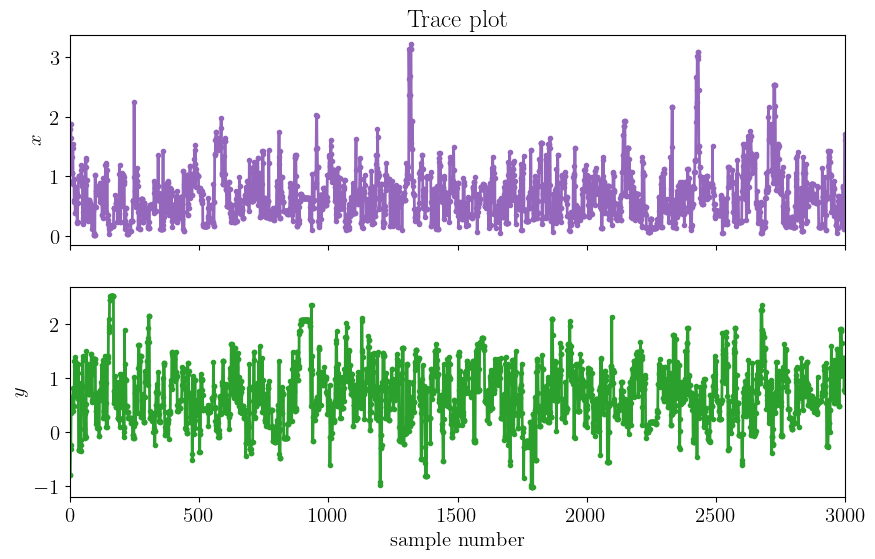

In [9]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10,6), sharex=True)
ax0.set_ylabel("$x$")
ax0.set_title("Trace plot")
ax0.plot(np.arange(Nsamp),samples.T[0],marker='.',color='C4')
ax1.set_xlim([0,Nsamp])
ax1.set_xlabel("sample number")
ax1.set_ylabel("$y$")
ax1.plot(np.arange(Nsamp),samples.T[1],marker='.',color='C2')
plt.savefig(dir+'Hamiltonian_2nd_order_trace_plot.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Hamiltonian_2nd_order_trace_plot.png',dpi=300,bbox_inches="tight")
plt.show()

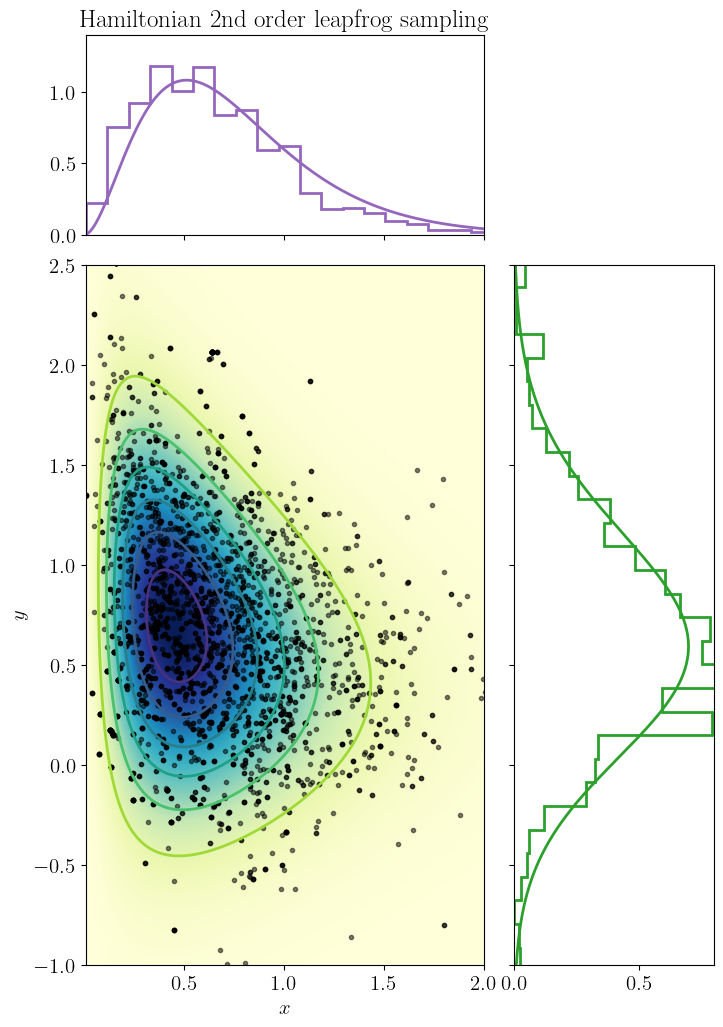

In [10]:
nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0., xmax-xmin
bottom, height = 0., ymax-ymin
left_h = left + width + 0.15
bottom_h = bottom + height + 0.15

rect_pdf = [left, bottom, width, height]
rect_pdfx = [left, bottom_h, width, 1.]
rect_pdfy = [left_h, bottom, 1., height]

# start with a rectangular Figure
plt.figure(1, figsize=(2, 2))

ax = plt.axes(rect_pdf)
axpdfx = plt.axes(rect_pdfx)
axpdfy = plt.axes(rect_pdfy)

# no labels
axpdfx.xaxis.set_major_formatter(nullfmt)
axpdfy.yaxis.set_major_formatter(nullfmt)

# the 2D plot:
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.imshow(Z,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='YlGnBu')
ax.contour(X,Y,Z,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='viridis_r')
ax.scatter(samples.T[0], samples.T[1], marker='.', color='black', alpha=0.5)

# the marginals:
axpdfx.set_xlim(xmin,xmax)
axpdfx.set_ylim([0,1.4])
axpdfx.plot(x,target_marginal_x(x)/Nx,color='C4')
axpdfx.hist(samples.T[0],30,density=True,histtype='step',color='C4',linewidth=2.)

axpdfy.set_xlim([0,0.8])
axpdfy.set_ylim(ymin,ymax)
axpdfy.plot(target_marginal_y(y)/Ny,y,color='C2')
axpdfy.hist(samples.T[1],30,density=True,histtype='step',color='C2',linewidth=2.,orientation='horizontal')

axpdfx.set_title("Hamiltonian 2nd order leapfrog sampling")
plt.savefig(dir+'Hamiltonian_2nd_order_target_pdf_and_samples.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Hamiltonian_2nd_order_target_pdf_and_samples.png',dpi=300,bbox_inches="tight")
plt.show()

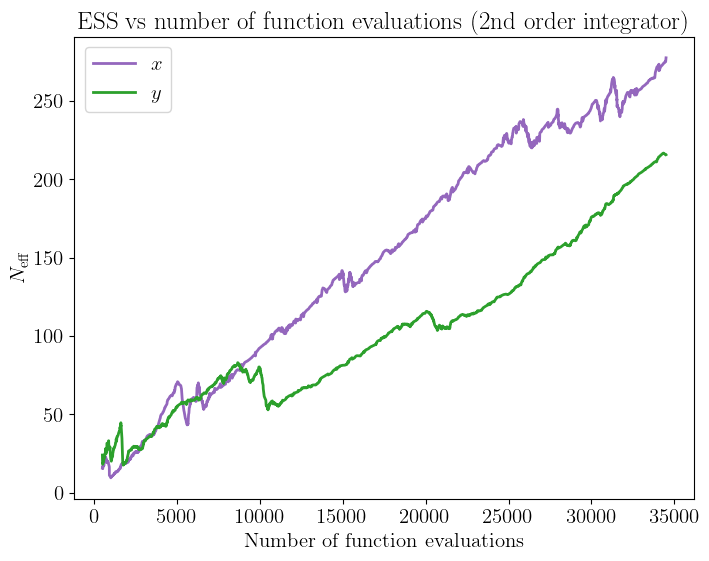

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(Ncalls_dpsi_dx[50:],Neff_x[50:],color='C4',label="$x$")
ax.plot(Ncalls_dpsi_dy[50:],Neff_y[50:],color='C2',label="$y$")
ax.set_xlabel("Number of function evaluations")
ax.set_ylabel("$N_\mathrm{eff}$")
ax.set_title("ESS vs number of function evaluations (2nd order integrator)")
ax.legend(loc="best")
plt.savefig(dir+'Hamiltonian_2nd_order_ESS.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Hamiltonian_2nd_order_ESS.png',dpi=300,bbox_inches="tight")
plt.show()

## HMC with fourth-order integrator

In [12]:
def fourth_order_move(dpsi_dx,Ncalls_dpsi_dx_current,dpsi_dy,Ncalls_dpsi_dy_current,InvMassMatrix,dpsidx,dpsidy,x,y,p_x,p_y,epsilon,i,s):
    # i forward steps
    for _ in range(i):
        dpsidx,dpsidy,x,y,p_x,p_y,Ncalls_dpsi_dx_current,Ncalls_dpsi_dy_current = leapfrog_move(dpsi_dx,Ncalls_dpsi_dx_current,dpsi_dy,Ncalls_dpsi_dy_current,InvMassMatrix,dpsidx,dpsidy,x,y,p_x,p_y,epsilon)

    # one backward step
    dpsidx,dpsidy,x,y,p_x,p_y,Ncalls_dpsi_dx_current,Ncalls_dpsi_dy_current = leapfrog_move(dpsi_dx,Ncalls_dpsi_dx_current,dpsi_dy,Ncalls_dpsi_dy_current,InvMassMatrix,dpsidx,dpsidy,x,y,p_x,p_y,-s*epsilon)

    # i forward steps
    for _ in range(i):
        dpsidx,dpsidy,x,y,p_x,p_y,Ncalls_dpsi_dx_current,Ncalls_dpsi_dy_current = leapfrog_move(dpsi_dx,Ncalls_dpsi_dx_current,dpsi_dy,Ncalls_dpsi_dy_current,InvMassMatrix,dpsidx,dpsidy,x,y,p_x,p_y,epsilon)

    return dpsidx,dpsidy,x,y,p_x,p_y,Ncalls_dpsi_dx_current,Ncalls_dpsi_dy_current

def Hamiltonian_fourthorder_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix,stepsize,i,s,Nsamp,x_start,y_start):
    InvMassMatrix=np.linalg.inv(MassMatrix)
    Naccepted=0
    x=x_start
    y=y_start
    samples_x=[x]
    samples_y=[y]
    Ncalls_psi=[0]
    Ncalls_psi_current=0
    Ncalls_dpsi_dx=[0]
    Ncalls_dpsi_dx_current=0
    Ncalls_dpsi_dy=[0]
    Ncalls_dpsi_dy_current=0
    Neff_x=[0]
    Neff_y=[0]
    for _ in range(Nsamp-1):
        # compute potential energy and gradient
        old_x = x
        old_y = y
        old_psi, Ncalls_psi_current = psi(old_x,old_y,Ncalls=Ncalls_psi_current)
        dpsidx, Ncalls_dpsi_dx_current = dpsi_dx(old_x,old_y,Ncalls=Ncalls_dpsi_dx_current)
        dpsidy, Ncalls_dpsi_dy_current = dpsi_dy(old_x,old_y,Ncalls=Ncalls_dpsi_dy_current)

        # randomly draw momenta
        p_x = norm(0.,1.).rvs()
        p_y = norm(0.,1.).rvs()
        p = np.array((p_x,p_y))

        # compute kinetic energy
        old_K = p.T.dot(InvMassMatrix).dot(p)/2.

        # compute Hamiltonian
        old_H = old_K + old_psi

        # do one fourth-order integration step
        # draw stepsize
        epsilon = uniform.rvs()*stepsize

        # call leapfrog move
        dpsidx,dpsidy,x,y,p_x,p_y,Ncalls_dpsi_dx_current,Ncalls_dpsi_dy_current = fourth_order_move(dpsi_dx,Ncalls_dpsi_dx_current,dpsi_dy,Ncalls_dpsi_dy_current,InvMassMatrix,dpsidx,dpsidy,x,y,p_x,p_y,epsilon,i,s)

        # compute new energy and Hamiltonian
        new_x=x; new_y=y
        new_psi = psi(new_x,new_y)
        p = np.array((p_x,p_y))
        new_K = p.T.dot(InvMassMatrix).dot(p)/2.
        new_H = new_K + new_psi
        dH = new_H - old_H

        # accept/reject new candidate x,y using the standard Metropolis-Hastings rule
        if(x<0.):
            accept=False
        else:
            if(dH<0.0):
                accept=True
            else:
                a = np.exp(-dH)
                u = np.random.uniform()
                if(u < a):
                    accept=True
                else:
                    accept=False

        if(accept):
            x=new_x
            y=new_y
            Naccepted+=1
        else:
            x=old_x
            y=old_y
        samples_x.append(x)
        samples_y.append(y)
        Ncalls_psi.append(Ncalls_psi_current)
        Ncalls_dpsi_dx.append(Ncalls_dpsi_dx_current)
        Ncalls_dpsi_dy.append(Ncalls_dpsi_dy_current)
        Neff_x.append(N_eff(samples_x))
        Neff_y.append(N_eff(samples_y))

    samples = np.column_stack((samples_x, samples_y))
    return Naccepted, samples, np.array(Ncalls_psi), np.array(Ncalls_dpsi_dx), np.array(Ncalls_dpsi_dy), np.array(Neff_x), np.array(Neff_y)

In [13]:
Nsamp=3000
x_start=1.8
y_start=-0.8
MassMatrix=np.array([[1., 0.], [0., 1.]])
i=3
s=(2*i)**(1/3.)
stepsize=0.1
Naccepted,samples,Ncalls_psi,Ncalls_dpsi_dx,Ncalls_dpsi_dy,Neff_x,Neff_y=Hamiltonian_fourthorder_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix,stepsize,i,s,Nsamp,x_start,y_start)

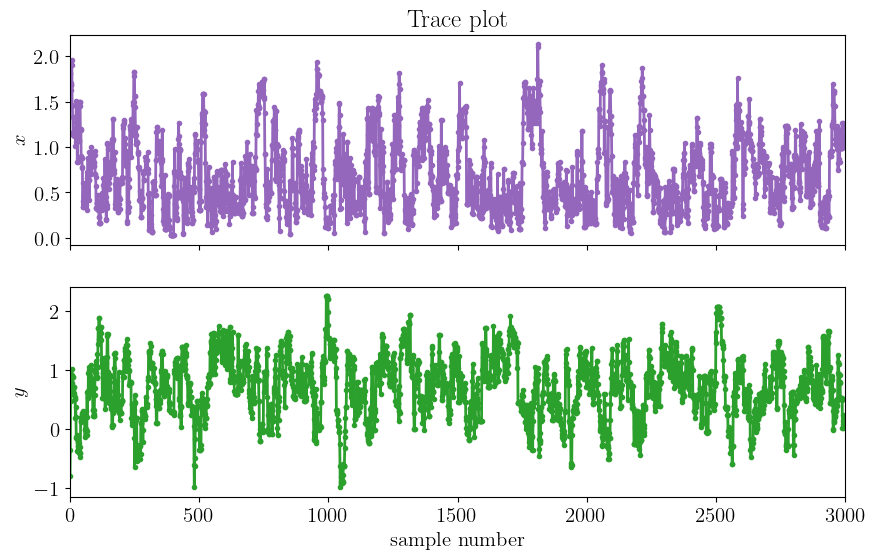

In [14]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10,6), sharex=True)
ax0.set_ylabel("$x$")
ax0.set_title("Trace plot")
ax0.plot(np.arange(Nsamp),samples.T[0],marker='.',color='C4')
ax1.set_xlim([0,Nsamp])
ax1.set_xlabel("sample number")
ax1.set_ylabel("$y$")
ax1.plot(np.arange(Nsamp),samples.T[1],marker='.',color='C2')
plt.savefig(dir+'Hamiltonian_4th_order_trace_plot.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Hamiltonian_4th_order_trace_plot.png',dpi=300,bbox_inches="tight")
plt.show()

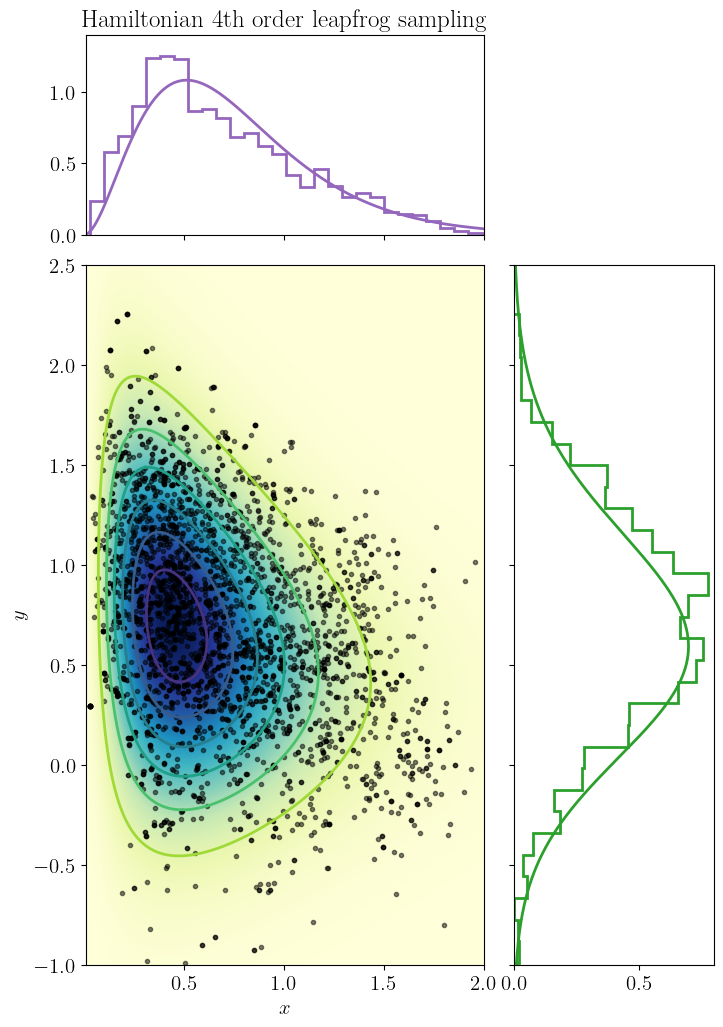

In [15]:
nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0., xmax-xmin
bottom, height = 0., ymax-ymin
left_h = left + width + 0.15
bottom_h = bottom + height + 0.15

rect_pdf = [left, bottom, width, height]
rect_pdfx = [left, bottom_h, width, 1.]
rect_pdfy = [left_h, bottom, 1., height]

# start with a rectangular Figure
plt.figure(1, figsize=(2, 2))

ax = plt.axes(rect_pdf)
axpdfx = plt.axes(rect_pdfx)
axpdfy = plt.axes(rect_pdfy)

# no labels
axpdfx.xaxis.set_major_formatter(nullfmt)
axpdfy.yaxis.set_major_formatter(nullfmt)

# the 2D plot:
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.imshow(Z,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='YlGnBu')
ax.contour(X,Y,Z,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='viridis_r')
ax.scatter(samples.T[0], samples.T[1], marker='.', color='black', alpha=0.5)

# the marginals:
axpdfx.set_xlim(xmin,xmax)
axpdfx.set_ylim([0,1.4])
axpdfx.plot(x,target_marginal_x(x)/Nx,color='C4')
axpdfx.hist(samples.T[0],30,density=True,histtype='step',color='C4',linewidth=2.)

axpdfy.set_xlim([0,0.8])
axpdfy.set_ylim(ymin,ymax)
axpdfy.plot(target_marginal_y(y)/Ny,y,color='C2')
axpdfy.hist(samples.T[1],30,density=True,histtype='step',color='C2',linewidth=2.,orientation='horizontal')

axpdfx.set_title("Hamiltonian 4th order leapfrog sampling")
plt.savefig(dir+'Hamiltonian_4th_order_target_pdf_and_samples.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Hamiltonian_4th_order_target_pdf_and_samples.png',dpi=300,bbox_inches="tight")
plt.show()

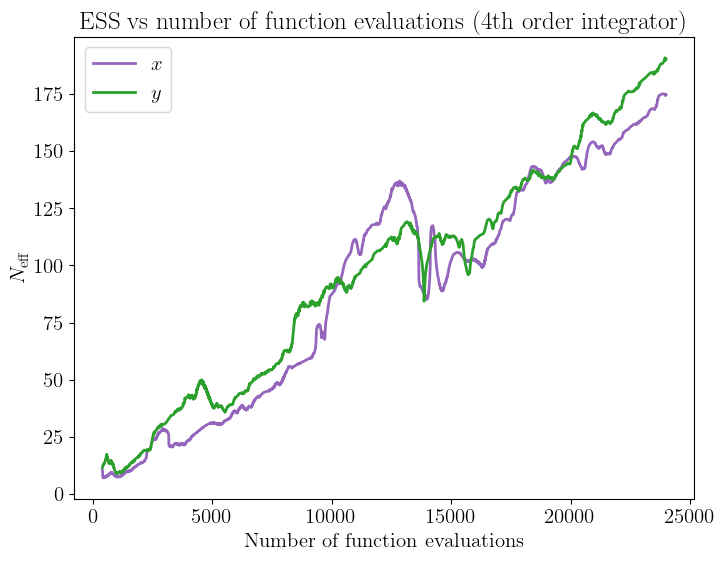

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(Ncalls_dpsi_dx[50:],Neff_x[50:],color='C4',label="$x$")
ax.plot(Ncalls_dpsi_dy[50:],Neff_y[50:],color='C2',label="$y$")
ax.set_xlabel("Number of function evaluations")
ax.set_ylabel("$N_\mathrm{eff}$")
ax.set_title("ESS vs number of function evaluations (4th order integrator)")
ax.legend(loc="best")
plt.savefig(dir+'Hamiltonian_4th_order_ESS.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Hamiltonian_4th_order_ESS.png',dpi=300,bbox_inches="tight")
plt.show()

## Comparison of sampler efficiencies

In [17]:
Nsamp=3000
x_start=1.8
y_start=-0.8
MassMatrix=np.array([[1., 0.], [0., 1.]])
stepsize=0.1

In [18]:
Neval=5
Naccepted_A1,samples_A1,Ncalls_psi_A1,Ncalls_dpsi_dx_A1,Ncalls_dpsi_dy_A1,Neff_x_A1,Neff_y_A1=Hamiltonian_leapfrog_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix,Neval,stepsize,Nsamp,x_start,y_start)
Neval=20
Naccepted_A2,samples_A2,Ncalls_psi_A2,Ncalls_dpsi_dx_A2,Ncalls_dpsi_dy_A2,Neff_x_A2,Neff_y_A2=Hamiltonian_leapfrog_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix,Neval,stepsize,Nsamp,x_start,y_start)
Neval=50
Naccepted_A3,samples_A3,Ncalls_psi_A3,Ncalls_dpsi_dx_A3,Ncalls_dpsi_dy_A3,Neff_x_A3,Neff_y_A3=Hamiltonian_leapfrog_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix,Neval,stepsize,Nsamp,x_start,y_start)

In [19]:
i=1
s=(2*i)**(1/3.)
Naccepted_B1,samples_B1,Ncalls_psi_B1,Ncalls_dpsi_dx_B1,Ncalls_dpsi_dy_B1,Neff_x_B1,Neff_y_B1=Hamiltonian_fourthorder_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix,stepsize,i,s,Nsamp,x_start,y_start)
i=2
s=(2*i)**(1/3.)
Naccepted_B2,samples_B2,Ncalls_psi_B2,Ncalls_dpsi_dx_B2,Ncalls_dpsi_dy_B2,Neff_x_B2,Neff_y_B2=Hamiltonian_fourthorder_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix,stepsize,i,s,Nsamp,x_start,y_start)
i=3
s=(2*i)**(1/3.)
Naccepted_B3,samples_B3,Ncalls_psi_B3,Ncalls_dpsi_dx_B3,Ncalls_dpsi_dy_B3,Neff_x_B3,Neff_y_B3=Hamiltonian_fourthorder_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix,stepsize,i,s,Nsamp,x_start,y_start)
i=4
s=(2*i)**(1/3.)
Naccepted_B4,samples_B4,Ncalls_psi_B4,Ncalls_dpsi_dx_B4,Ncalls_dpsi_dy_B4,Neff_x_B4,Neff_y_B4=Hamiltonian_fourthorder_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix,stepsize,i,s,Nsamp,x_start,y_start)

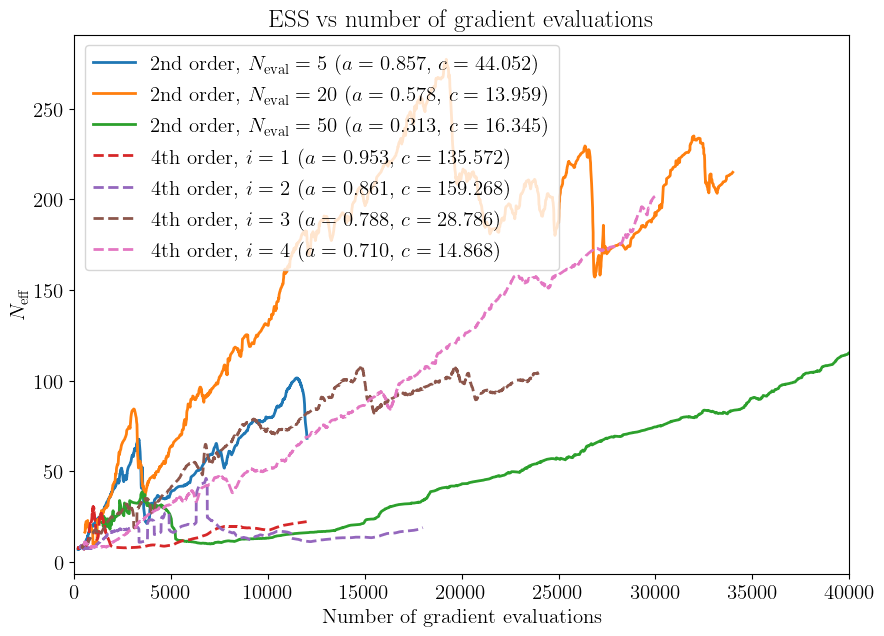

In [20]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_xlim([0,40000])
ax.plot(Ncalls_dpsi_dx_A1[50:],Neff_x_A1[50:],linestyle="-",label="2nd order, $N_\mathrm{{eval}}=5$ ($a={:.3f}$, $c={:.3f})$".format(Naccepted_A1/Nsamp, autocorr_gw2010(samples_A1[:,0])))
ax.plot(Ncalls_dpsi_dx_A2[50:],Neff_x_A2[50:],linestyle="-",label="2nd order, $N_\mathrm{{eval}}=20$ ($a={:.3f}$, $c={:.3f})$".format(Naccepted_A2/Nsamp, autocorr_gw2010(samples_A2[:,0])))
ax.plot(Ncalls_dpsi_dx_A3[50:],Neff_x_A3[50:],linestyle="-",label="2nd order, $N_\mathrm{{eval}}=50$ ($a={:.3f}$, $c={:.3f})$".format(Naccepted_A3/Nsamp, autocorr_gw2010(samples_A3[:,0])))
ax.plot(Ncalls_dpsi_dx_B1[50:],Neff_x_B1[50:],linestyle="--",label="4th order, $i=1$ ($a={:.3f}$, $c={:.3f})$".format(Naccepted_B1/Nsamp, autocorr_gw2010(samples_B1[:,0])))
ax.plot(Ncalls_dpsi_dx_B2[50:],Neff_x_B2[50:],linestyle="--",label="4th order, $i=2$ ($a={:.3f}$, $c={:.3f})$".format(Naccepted_B2/Nsamp, autocorr_gw2010(samples_B2[:,0])))
ax.plot(Ncalls_dpsi_dx_B3[50:],Neff_x_B3[50:],linestyle="--",label="4th order, $i=3$ ($a={:.3f}$, $c={:.3f})$".format(Naccepted_B3/Nsamp, autocorr_gw2010(samples_B3[:,0])))
ax.plot(Ncalls_dpsi_dx_B4[50:],Neff_x_B4[50:],linestyle="--",label="4th order, $i=4$ ($a={:.3f}$, $c={:.3f})$".format(Naccepted_B4/Nsamp, autocorr_gw2010(samples_B4[:,0])))
ax.set_xlabel("Number of gradient evaluations")
ax.set_ylabel("$N_\mathrm{eff}$")
ax.set_title("ESS vs number of gradient evaluations")
plt.savefig(dir+'Hamiltonian_ESS_comparison_1.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Hamiltonian_ESS_comparison_1.png',dpi=300,bbox_inches="tight")
plt.legend(loc="best")

In [21]:
stepsize=0.185
Neval=9
Naccepted_C1,samples_C1,Ncalls_psi_C1,Ncalls_dpsi_dx_C1,Ncalls_dpsi_dy_C1,Neff_x_C1,Neff_y_C1=Hamiltonian_leapfrog_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix,Neval,stepsize,Nsamp,x_start,y_start)

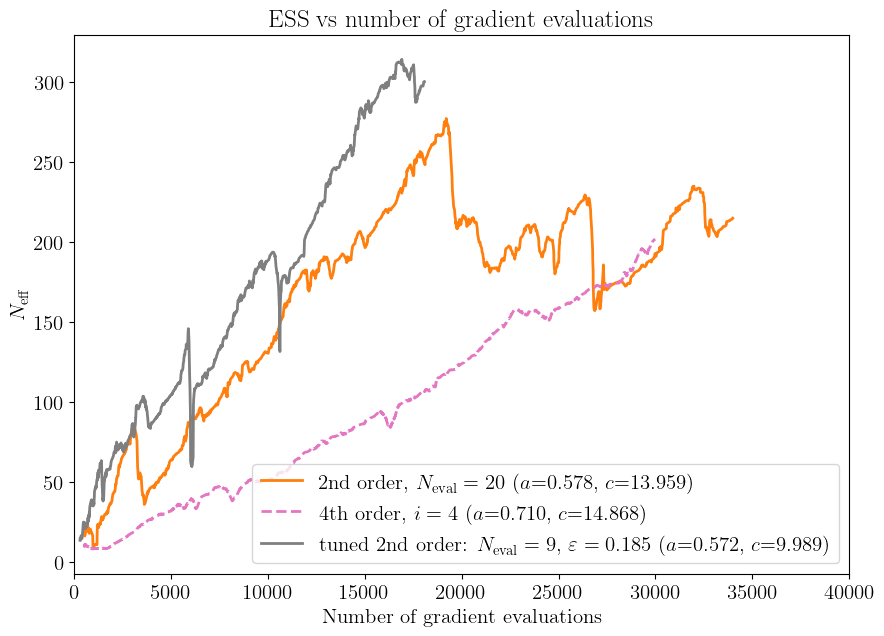

In [22]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_xlim([0,40000])
ax.plot(Ncalls_dpsi_dx_A2[50:],Neff_x_A2[50:],linestyle="-",color='C1',label="2nd order, $N_\mathrm{{eval}}=20$ ($a$={:.3f}, $c$={:.3f})".format(Naccepted_A2/Nsamp, autocorr_gw2010(samples_A2[:,0])))
ax.plot(Ncalls_dpsi_dx_B4[50:],Neff_x_B4[50:],linestyle="--",color='C6',label="4th order, $i=4$ ($a$={:.3f}, $c$={:.3f})".format(Naccepted_B4/Nsamp, autocorr_gw2010(samples_B4[:,0])))
ax.plot(Ncalls_dpsi_dx_C1[50:],Neff_x_C1[50:],linestyle="-",color='C7',label="tuned 2nd order: $N_\mathrm{{eval}}=9$, $\\varepsilon=0.185$ ($a$={:.3f}, $c$={:.3f})".format(Naccepted_C1/Nsamp, autocorr_gw2010(samples_C1[:,0])))
ax.set_xlabel("Number of gradient evaluations")
ax.set_ylabel("$N_\mathrm{eff}$")
ax.set_title("ESS vs number of gradient evaluations")
plt.savefig(dir+'Hamiltonian_ESS_comparison_2.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Hamiltonian_ESS_comparison_2.png',dpi=300,bbox_inches="tight")
plt.legend(loc="best")